In [22]:
import os
import math
import pandas as pd
import numpy as np
import sys
import json
from numpy.linalg import norm
import constants
from numpy import cross, pi
from numpy.linalg import norm
import plotly.express as px
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#%matplotlib inline
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from pathlib import Path
import pickle
from ai import cs
import openpyxl

from numpy import pi
import seaborn as sns
mu = 3.986004418e14
earth_radius = 6356000

In [16]:
def read_spaceobjects_json(filename):
    with open(filename, 'r') as f:
        jsondata = json.load(f)
    return jsondata

In [17]:
def preprocess_data(jsondata):
    """
    data = []
    data.keys()
    ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10']
    
    data['0'].keys()
    ['Objects', 'LastUpdateTime']
    
    type(data['0']['LastUpdateTime'])
    str
    
    type(data['0']['Objects'])
    list
    
    type(data['0']['Objects'][0])
    dict
    
    data['0']['Objects'][0].keys()
    
    ['CatalogId', 'NoradId', 'Name', 'BallCoeff', 'Birthdate', 'Country', 'Epoch', 'Cart', 'SMA', 'Ecc', 'Inc', 'RAAN', 'ArgP', 'MeanAnom', 'EquEx', 'EquEy', 'EquHx', 'EquHy', 'EquLm', 'OrbitType']
    
    EquEx = e*cos(omega + Omega)
    EquEy = e*sin(omega + Omega)
    EquHx = tan(i/2)*cos(Omega)
    EquHy = tan(i/2)*sin(Omega)
    l_nu = nu + omega + Omega
    EquLm = MeanAnom + omega + Omega

    #columns of output are as follows:

    Index(['CatalogId', 'NoradId', 'Name', 'BallCoeff', 'Country', 'Epoch', 'SMA',
           'Ecc', 'Inc', 'RAAN', 'ArgP', 'MeanAnom', 'EquEx', 'EquEy', 'EquHx',
           'EquHy', 'EquLm', 'OrbitType', 'BirthDate', 'DragCoeff', 'ReflCoeff',
           'AreaToMass', 'Operator', 'Users', 'Purpose', 'DetailedPurpose',
           'LaunchMass', 'DryMass', 'Power', 'Lifetime', 'Contractor',
           'LaunchSite', 'LaunchVehicle', 'energy', 'r_0', 'r_1', 'r_2', 'v_0',
           'v_1', 'v_2', 'h_0', 'h_1', 'h_2', 'lrl_0', 'lrl_1', 'lrl_2', 'perigee',
           'apogee', 'perigee_altitude', 'apogee_altitude', 'period'],
          dtype='object')
    
"""
    data = []
    for num in jsondata:
        data += jsondata[num]['Objects']

    df = pd.DataFrame(data)
    df = df[pd.notnull(df.Cart)] # Purge rows with a missing 'Cart' value
    df = df[df['SMA'] > 0]

    positions = [x[:3] for x in df.Cart]
    velocities = [x[3:] for x in df.Cart]

    energies = [norm(v)**2 / 2 - mu/norm(r) for (r, v) in zip(positions, velocities)]
    df['energy'] = energies

    h_vectors = [cross(r, v) for (r, v) in zip(positions, velocities)]
    lrl_vectors = [(cross(v, h) / mu) - (r/norm(r)) for (r, v, h) in zip(positions, velocities, h_vectors)]

    def flatten(vector_list, name):
        vector_array = np.array(vector_list)
        df = pd.DataFrame(vector_array)
        df = df.add_prefix(name + '_')

        return df

    positions = flatten(positions, 'r')
    velocities = flatten(velocities, 'v')
    h_vectors = flatten(h_vectors, 'h')
    lrl_vectors = flatten(lrl_vectors, 'lrl')

    df = df.drop(columns=['Cart'])
    df = pd.concat([df, positions, velocities, h_vectors, lrl_vectors], axis='columns')

    df['perigee'] = df['SMA'] * (1 - df['Ecc'])
    df['apogee'] = df['SMA'] * (1 + df['Ecc'])
    df['perigee_altitude'] = df['perigee'] - earth_radius
    df['apogee_altitude'] = df['apogee'] - earth_radius

    df['period'] = 2*pi * np.sqrt(df['SMA']**3 / mu)

    return df

def purge_outliers(data):
    """
    Index(['CatalogId', 'NoradId', 'Name', 'BallCoeff', 'Country', 'Epoch', 'SMA',
       'Ecc', 'Inc', 'RAAN', 'ArgP', 'MeanAnom', 'EquEx', 'EquEy', 'EquHx',
       'EquHy', 'EquLm', 'OrbitType', 'BirthDate', 'DragCoeff', 'ReflCoeff',
       'AreaToMass', 'Operator', 'Users', 'Purpose', 'DetailedPurpose',
       'LaunchMass', 'DryMass', 'Power', 'Lifetime', 'Contractor',
       'LaunchSite', 'LaunchVehicle', 'SpecificEnergy', 'LRL0', 'LRL1', 'LRL2',
       'SpecificAngularMomentum0', 'SpecificAngularMomentum1',
       'SpecificAngularMomentum2', 'Position0', 'Position1', 'Position2',
       'Velocity0', 'Velocity1', 'Velocity2'],
      dtype='object')
    """  

    data = data[np.logical_and(data.Ecc > 0 , data.Ecc < 1)]

    hlim = 1.2e11
    for i in ["0", "1",]:
        col = "h_" + i
        data = data[np.abs(data[col]) < hlim]

    data = data[np.logical_and(data["h_2"] > -5.6e10,
                               data["h_2"] < 1.4e11,)]

    nullable_entries = data[[
        'SMA', 'Ecc', 'Inc', 'RAAN', 'ArgP', 'MeanAnom',
        'EquEx', 'EquEy', 'EquHx', 'EquHy', 'EquLm',
        'energy',
        'lrl_0', 'lrl_1', 'lrl_2',
        'h_0', 'h_1', 'h_2',
        'r_0', 'r_1', 'r_2', 
        'v_0', 'v_1', 'v_2', 
        ]]

    notnulls = nullable_entries.notnull().any(axis=1)
    notinfs = nullable_entries[nullable_entries != np.inf].any(axis=1)
    records_to_keep = np.logical_and(notnulls, notinfs)

    data = data[records_to_keep]

    return data

In [18]:
def average_labels(new_data):
    dfObj_1 = pd.DataFrame()
    dfObj_2 = pd.DataFrame()
    dfObj_3 = pd.DataFrame()
    
    for i in range(0,35):
        inc_label = new_data.loc[new_data['predictions'] == i]
        h_0_avg = inc_label[["h_0"]].mean(axis=0)    
        dfObj_1 = dfObj_1.append(h_0_avg, ignore_index = True)
    for i in range(0,35):
        inc_label = new_data.loc[new_data['predictions'] == i]   
        h_1_avg = inc_label[["h_1"]].mean(axis=0)
        dfObj_2 = dfObj_2.append(h_1_avg, ignore_index = True)
    for i in range(0,35):
        inc_label = new_data.loc[new_data['predictions'] == i]   
        h_2_avg = inc_label[["h_2"]].mean(axis=0)
        dfObj_3 = dfObj_3.append(h_2_avg, ignore_index = True)
    mean_coordinates = pd.concat([dfObj_1, dfObj_2, dfObj_3], axis=1)
    return mean_coordinates
               

In [73]:
jsondata=read_spaceobjects_json('Clusters/SpaceObjects-20191201.json')
a=preprocess_data(jsondata)
df=purge_outliers(a)
uns_df=df[['energy','h_0','h_1', 'h_2', 
           'lrl_0', 'lrl_1', 'lrl_2']]
uns_df['h_mag'] = (uns_df['h_0']**2) + (uns_df['h_1']**2) + (uns_df['h_2']**2)
uns_df['h_mag'] = np.sqrt(uns_df['h_mag'])
# Y = uns_df[['h_0','h_1','h_2']].values
Y = uns_df[['h_mag']].values
kmeans_1 = KMeans(n_clusters=3, random_state=0).fit(Y)
predictions = kmeans_1.predict(Y)
uns_df = uns_df.assign(Month = predictions)
uns_df = uns_df.assign(NoradId = df["NoradId"])
year_df = pd.concat([uns_df['NoradId'], uns_df['Month']], axis=1, keys=['NoradId', 'Month01'])
# ground_truth = average_labels(uns_df)

<ipython-input-73-51e46c815642>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-73-51e46c815642>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(40000000000.0, 140000000000.0)

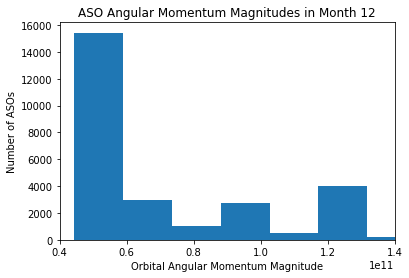

In [74]:
plt.hist(uns_df['h_mag'], 10)
plt.title("ASO Angular Momentum Magnitudes in Month 12")
plt.xlabel("Orbital Angular Momentum Magnitude")
plt.ylabel("Number of ASOs")
plt.xlim(0.4*10**11, 1.4*10**11)

In [37]:
# loop to create dataframe with cluster numbers for whole year, using Jan as baseline for cluster locations
year_df = pd.DataFrame()
jsondata=read_spaceobjects_json('Clusters/SpaceObjects-20190101.json')
a=preprocess_data(jsondata)
df=purge_outliers(a)
uns_df=df[['energy','h_0','h_1', 'h_2', 
           'lrl_0', 'lrl_1', 'lrl_2']]
uns_df['h_mag'] = (uns_df['h_0']**2) + (uns_df['h_1']**2) + (uns_df['h_2']**2)
uns_df['h_mag'] = np.sqrt(uns_df['h_mag'])
# Y = uns_df[['h_0','h_1','h_2']].values
Y = uns_df[['h_mag']].values
kmeans_1 = KMeans(n_clusters=3, random_state=0).fit(Y)
predictions = kmeans_1.predict(Y)
uns_df = uns_df.assign(Monthr01 = predictions)
uns_df = uns_df.assign(NoradId = df["NoradId"])
uns_df['NoradId'] = pd.to_numeric(uns_df['NoradId'])
uns_df['Month01'] = pd.to_numeric(uns_df['Monthr01'])
year_df = pd.concat([uns_df['NoradId']], axis=1, keys=['NoradId'])
cluster_dict = dict(zip(uns_df['NoradId'], uns_df['Month01']))
year_df['Month01'] = np.nan
clean_dict = {
    k: v
    for k,
    v in cluster_dict.items() if k == k
}
for key in clean_dict:
    if key in year_df['NoradId'].values:
        year_df.loc[year_df['NoradId']== key,'Month01'] = clean_dict[key]
    else:
        new_row = {'NoradId': key, 'Month01': clean_dict[key]}
        year_df = year_df.append(new_row, ignore_index = True)

for i in range(2, 13):
    if i < 10:
        jsondata=read_spaceobjects_json('Clusters/SpaceObjects-20190'+str(i)+'01.json')
    else:
        jsondata=read_spaceobjects_json('Clusters/SpaceObjects-2019'+str(i)+'01.json')
    a=preprocess_data(jsondata)
    df=purge_outliers(a)
    uns_df=df[['energy','h_0','h_1', 'h_2', 
           'lrl_0', 'lrl_1', 'lrl_2']]
    uns_df['h_mag'] = (uns_df['h_0']**2) + (uns_df['h_1']**2) + (uns_df['h_2']**2)
    uns_df['h_mag'] = np.sqrt(uns_df['h_mag'])
    # Y = uns_df[['h_0','h_1','h_2']].values
    Y = uns_df[['h_mag']].values
    predictions = kmeans_1.predict(Y)
    uns_df = uns_df.assign(Month = predictions)
    uns_df = uns_df.assign(NoradId = df["NoradId"])
    uns_df['NoradId'] = pd.to_numeric(uns_df['NoradId'])
    uns_df['Month'] = pd.to_numeric(uns_df['Month'])
    cluster_dict = dict(zip(uns_df['NoradId'], uns_df['Month']))
    year_df['Month0{}'.format(i)] = np.nan
    clean_dict = {
       k: v
       for k,
       v in cluster_dict.items() if k == k
    }
    for key in clean_dict:
        if key in year_df['NoradId'].values:
            year_df.loc[year_df['NoradId']== key,'Month0{}'.format(i)] = clean_dict[key]
        else:
            new_row = {'NoradId': key, 'Month0{}'.format(i): clean_dict[key]}
            year_df = year_df.append(new_row, ignore_index = True)
print(year_df)

<ipython-input-37-5aeed95e709d>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-37-5aeed95e709d>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-37-5aeed95e709d>:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-37-5aeed9

       NoradId  Month01  Month02  Month03  Month04  Month05  Month06  Month07  \
0          5.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1         11.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2         12.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3         16.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4         20.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
24774  44806.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
24775  44813.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
24776  44819.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
24777  44820.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
24778  82529.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

       Month08  Month09  Mo

In [214]:
print(len(year_df['NoradId']) - len(year_df['NoradId'].unique()))
print(year_df['NoradId'].isna().sum())
print(81821 in year_df['NoradId'].values)

5286
4117
True


In [38]:
year_df = year_df.dropna(subset = ["NoradId"])
year_df.to_excel(r'MagClustersv1.xlsx', index = False)

In [1]:
# plt.plot(K, distortions, 'bx-') 
# plt.xlabel('Values of K') 
# plt.ylabel('Distortion') 
# plt.title('The Elbow Method using Distortion') 
# plt.show() 

In [39]:
print(kmeans_1.cluster_centers_)
print(uns_df)

[[5.61131604e+10]
 [1.28222199e+11]
 [9.18700148e+10]]
             energy           h_0           h_1           h_2     lrl_0  \
0     -2.879023e+07 -3.639623e+10 -3.056558e+10  2.236853e+10  0.000354   
1     -2.823160e+07 -5.089651e+10 -1.315034e+10 -7.062861e+09 -0.000854   
2     -2.861491e+07 -5.109984e+10  1.065356e+10 -7.177333e+09  0.000434   
3     -2.855698e+07 -5.111106e+10  1.086361e+10 -7.175376e+09  0.000133   
4     -2.854693e+07 -5.114991e+10  1.072286e+10 -7.178455e+09  0.000224   
...             ...           ...           ...           ...       ...   
26849 -4.695094e+06  4.007438e+10 -3.359571e+10 -7.240060e+09 -0.000197   
26850 -4.726520e+06  3.819674e+10 -3.594565e+10 -7.569916e+09  0.001025   
26851 -4.721699e+06  5.185073e+10  1.978552e+09 -6.831897e+09  0.000171   
26852 -4.726852e+06  3.867781e+10 -3.590879e+10 -7.888990e+09  0.000353   
26853 -4.727076e+06  4.007440e+10 -3.359570e+10 -7.240054e+09 -0.000197   

          lrl_1     lrl_2         h_mag  Mon

In [31]:
distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(uns_df[['h_mag']].values)
    distortions.append(kmeanModel.inertia_)


In [32]:
print(distortions)

[1.8823168790756634e+25, 1.9324116028813602e+24, 7.517310465909249e+23, 2.1660282710512725e+23, 1.4463546483533999e+23, 1.0929488369065086e+23, 8.473791150059926e+22, 6.80149744589514e+22, 5.500657776572298e+22, 4.5410013460246164e+22, 3.941148353101997e+22, 3.4745273768200657e+22, 3.1494194528724554e+22, 2.8253176953020883e+22, 2.5113747928251367e+22, 2.2713459331596475e+22, 2.04326221349609e+22, 1.800124243817946e+22, 1.5875376732434288e+22, 1.459247487089447e+22, 1.3458314998041666e+22, 1.2130805264746839e+22, 1.1156526233519657e+22, 1.0131719241771736e+22, 9.231645938200648e+21, 8.518545928513851e+21, 7.611556472564978e+21, 7.291243648407675e+21, 6.918897746598979e+21, 6.531191110856942e+21, 6.045676060411277e+21, 5.738150157203354e+21, 5.550087189562864e+21, 5.143086463049723e+21, 4.877812956672757e+21, 4.627832087055965e+21, 4.4319724931835987e+21, 4.221295650481918e+21, 3.978817470878675e+21, 3.7639243030323627e+21, 3.588390052148628e+21, 3.436419703711812e+21, 3.260880801860337

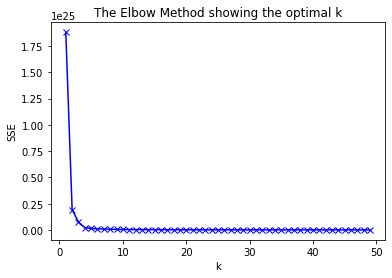

In [33]:
# plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [40]:
tuned_kmeans = KMeans(n_clusters=35, random_state=0)
predictions = tuned_kmeans.fit_predict(Y)
final_clusters = uns_df.assign(predictions = tuned_kmeans.labels_)

<AxesSubplot:>

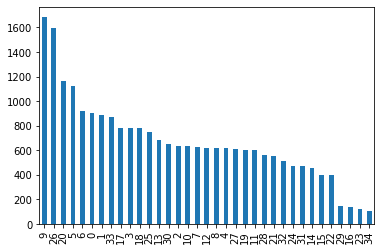

In [41]:
final_clusters['predictions'].value_counts().plot.bar()

In [12]:
perc = final_clusters['predictions'].value_counts(normalize=True) * 100

## Remapping Labels, Instantiating Ground Truth

In [13]:
def sub_labels(ground_truth, new_data_centers, new_df):
    from scipy.spatial import distance
    dists=[]
    #computing Euclidean distances
    for index, h_vectors in ground_truth.iterrows():  
        h_0 = h_vectors['h_0']
        h_1 = h_vectors['h_1']
        h_2 = h_vectors['h_2']
        truth_points = (h_0, h_1, h_2)    #truth mean coordinates in each row
        for index2, h_vectors2 in new_data_centers.iterrows(): 
                h_02 = h_vectors2['h_0']
                h_12 = h_vectors2['h_1']
                h_22 = h_vectors2['h_2']
                incorrect_points = (h_02, h_12, h_22)   #incorrect mean coordinates in each row
                d = distance.euclidean(truth_points, incorrect_points) 
                dists.append(d) 
                
                
    #splitting array, creating mapping between old and new labels
    remapped_df = pd.DataFrame()
    ar = np.array(dists)  
    splitting = np.split(ar, 35)
    for gt_label in range(0, len(splitting)):
        incorrect_label = np.argmin(splitting[gt_label])
        temp = new_df.loc[new_df['predictions'] == incorrect_label]
        temp['predictions'].replace({incorrect_label: gt_label}, inplace=True)
        remapped_df = remapped_df.append(temp, ignore_index = True)
    return remapped_df

In [14]:
def sub_labels(ground_truth, new_data_centers, new_df):
    from scipy.spatial import distance
    dists=[]
    #computing Euclidean distances
    for index, h_vectors in ground_truth.iterrows():  
        h_0 = h_vectors['h_0']
        h_1 = h_vectors['h_1']
        h_2 = h_vectors['h_2']
        truth_points = (h_0, h_1, h_2)    #truth mean coordinates in each row
        for index2, h_vectors2 in new_data_centers.iterrows(): 
                h_02 = h_vectors2['h_0']
                h_12 = h_vectors2['h_1']
                h_22 = h_vectors2['h_2']
                incorrect_points = (h_02, h_12, h_22)   #incorrect mean coordinates in each row
                d = distance.euclidean(truth_points, incorrect_points) 
                dists.append(d) 
                
                
    #splitting array, creating mapping between old and new labels
    remapped_df = pd.DataFrame()
    ar = np.array(dists)  
    splitting = np.split(ar, 35)
    di = {}
    for gt_label in range(0, len(splitting)):
        incorrect_label = np.argmin(splitting[gt_label])
        di[incorrect_label] = gt_label
    remapped_df = new_df.replace({'predictions':di})
    return remapped_df

In [19]:
final = sub_labels(ground_truth, not_truth, uns_df)

NameError: name 'not_truth' is not defined

In [16]:
final.shape

NameError: name 'final' is not defined

In [55]:
final

energy           h_0           h_1           h_2     lrl_0  \
0     -2.310745e+07 -1.355037e+10 -2.945246e+10  4.764891e+10 -0.111540   
1     -2.451503e+07  1.869614e+10  2.426152e+10  4.724948e+10  0.021125   
2     -2.394151e+07 -2.416206e+10 -1.910261e+10  4.771956e+10 -0.004423   
3     -2.259242e+07  7.925413e+09  3.176014e+10  4.796440e+10  0.011939   
4     -2.410131e+07  4.125477e+09  3.085944e+10  4.727921e+10  0.066836   
...             ...           ...           ...           ...       ...   
23536 -4.726464e+06  2.717040e+08 -3.303308e+07  1.296441e+11 -0.000217   
23537 -4.726484e+06  3.706115e+08 -5.520738e+07  1.296455e+11 -0.000172   
23538 -4.726363e+06  1.241905e+10 -7.979552e+09  1.292699e+11 -0.000218   
23539 -4.692708e+06  1.185343e+10 -6.700080e+09  1.293675e+11  0.000099   
23540 -4.694731e+06  1.174542e+10 -7.563748e+09  1.293925e+11  0.000166   

          lrl_1         lrl_2         Names  predictions  
0     -0.108184 -9.858958e-02    VANGUARD 1           22  
1      0.125660 -7.288265e-02    VANGUARD 2           22  
2     -0.153969 -6.387456e-02  VANGUARD R/B           22  
3      0.167623 -1.129661e-01  VANGUARD R/B           22  
4     -0.130396  7.927860e-02    VANGUARD 3           22  
...         ...           ...           ...          ...  
23536 -0.000028  4.469021e-07           NaN            6  
23537 -0.000198  4.079116e-07           NaN            6  
23538 -0.001255 -5.658546e-05           NaN           10  
23539 -0.000762 -4.852933e-05           NaN           10  
23540 -0.000750 -5.893406e-05           NaN           10  

[23533 rows x 9 columns]

In [17]:
#Instantiating a ground truth before using the remapping labels functions
jsondata=read_spaceobjects_json('SpaceObjects-20190101.json')
a=preprocess_data(jsondata)
df=purge_outliers(a)
uns_df=df[['energy','h_0','h_1', 'h_2', 
           'lrl_0', 'lrl_1', 'lrl_2']]
Y = uns_df[['h_0','h_1','h_2']].values
kmeans_1 = KMeans(n_clusters=35, random_state=0)
predictions = kmeans_1.fit_predict(Y)
uns_df = uns_df.assign(predictions = kmeans_1.labels_)
uns_df = average_labels(uns_df)
ground_truth = uns_df.assign(Names = df["Name"])

In [18]:
def cluster(data):
    jsondata=read_spaceobjects_json(data)
    a=preprocess_data(jsondata)
    df=purge_outliers(a)
    uns_df=df[['energy','h_0','h_1', 'h_2', 
           'lrl_0', 'lrl_1', 'lrl_2']]
    Y = uns_df[['h_0','h_1','h_2']].values
    kmeans_1 = KMeans(n_clusters=35, random_state=0)
    predictions = kmeans_1.fit_predict(Y)
    uns_df = uns_df.assign(Names = df["Name"])
    uns_df = uns_df.assign(predictions = kmeans_1.labels_)
    not_truth = average_labels(uns_df)
    final = sub_labels(ground_truth, not_truth, uns_df)
    return final

In [27]:
jan_cart = cluster('SpaceObjects-20190101.json')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



energy           h_0           h_1           h_2     lrl_0  \
0     -8.399763e+06  1.504755e+10 -5.812595e+09  6.595732e+10 -0.009142   
1     -6.864442e+06 -1.238628e+10  7.760920e+08  9.560488e+10 -0.280189   
2     -1.183469e+07  1.025076e+10  5.474215e+09  6.384603e+10 -0.366578   
3     -1.012579e+07  6.981753e+08 -1.215009e+10  6.501997e+10  0.490794   
4     -8.510564e+06 -8.031776e+09  9.720948e+08  6.862517e+10  0.279212   
...             ...           ...           ...           ...       ...   
24506 -8.415995e+06  3.965792e+09 -3.401890e+10  1.253951e+11  0.000748   
24507 -4.726758e+06  2.280649e+09 -3.383877e+10  1.253808e+11  0.000254   
24508 -4.726881e+06  3.525128e+09 -2.637590e+10  1.271818e+11  0.000678   
24509 -4.726133e+06 -4.266968e+08 -3.485243e+10  1.257856e+11 -0.000691   
24510 -4.726999e+06  1.505972e+09 -3.508293e+10  1.256968e+11  0.002592   

          lrl_1     lrl_2                 Names  predictions  
0     -0.713246 -0.060770        DELTA 1 R/B(2)            0  
1      0.341838 -0.039075       AYAME 2 (ECS-2)            0  
2      0.487798  0.017031                 CAT 3            0  
3     -0.440138 -0.087517                 CAT 4            0  
4      0.640273  0.023609  ARIANE 3 DEB (SYLDA)            0  
...         ...       ...                   ...          ...  
24506  0.004069  0.001080                   NaN           34  
24507 -0.000200 -0.000059                   NaN           34  
24508 -0.000119 -0.000043                   NaN           34  
24509  0.000269  0.000072                   NaN           34  
24510 -0.002697 -0.000784                   NaN           34  

[24511 rows x 9 columns]

## Converting to Cylindrical Coordinates

In [8]:
#Same code as above except trying to convert to cylindrical coordinates
jsondata=read_spaceobjects_json('SpaceObjects-20190201.json')
a=preprocess_data(jsondata)
df=purge_outliers(a)
uns_df=df[['energy','h_0','h_1', 'h_2', 
           'lrl_0', 'lrl_1', 'lrl_2']]
Y = uns_df[['h_0','h_1','h_2']].values
from ai import cs
x,y,z = Y[:,0], Y[:,1], Y[:,2]
r, phi, z = cs.cart2cyl(x=x, y=y, z=z)
polar_coords= np.stack((r,phi,z), axis=1)
kmeans_1 = KMeans(n_clusters=35, random_state=0)
predictions = kmeans_1.fit_predict(polar_coords)
dec = uns_df.assign(predictions = kmeans_1.labels_)
dec = dec.assign(Names = df["Name"])

In [9]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=[go.Scatter3d(x= dec['h_0'], y= dec['h_1'], z= dec['h_2'], mode='markers',
                        marker= dict(color= dec['predictions'] ,size=2)
                 )])
fig.show()

In [ ]:
import plotly as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [183]:
import plotly as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plt.offline.plot(fig, filename='dec_polar')

/opt/anaconda3/lib/python3.7/site-packages/plotly/offline/offline.py:563: UserWarning:

Your filename `dec_polar` didn't end with .html. Adding .html to the end of your file.



'dec_polar.html'

### Polar Plotting

In [22]:
#Instantiating a polar ground truth before using the remapping labels functions
jsondata=read_spaceobjects_json('SpaceObjects-20190101.json')
a=preprocess_data(jsondata)
df=purge_outliers(a)
uns_df=df[['energy','h_0','h_1', 'h_2', 
           'lrl_0', 'lrl_1', 'lrl_2']]
Y = uns_df[['h_0','h_1','h_2']].values
from ai import cs
x,y,z = Y[:,0], Y[:,1], Y[:,2]
r, phi, z = cs.cart2cyl(x=x, y=y, z=z)
polar_coords= np.stack((r,phi,z), axis=1)
kmeans_1 = KMeans(n_clusters=35, random_state=0)
predictions = kmeans_1.fit_predict(polar_coords)
uns_df = uns_df.assign(predictions = kmeans_1.labels_)
#uns_df = average_labels(uns_df)
ground_truth = uns_df.assign(Names = df["Name"])

NameError: name 'is_torch_available' is not defined

In [109]:
def polar_cluster(data, kmeans_1):
    jsondata=read_spaceobjects_json(data)
    a=preprocess_data(jsondata)
    df=purge_outliers(a)
    uns_df=df[['energy','h_0','h_1', 'h_2', 
               'lrl_0', 'lrl_1', 'lrl_2']]
    Y = uns_df[['h_0','h_1','h_2']].values
    x,y,z = Y[:,0], Y[:,1], Y[:,2]
    r, phi, z = cs.cart2cyl(x=x, y=y, z=z)
    polar_coords= np.stack((r,phi,z), axis=1)
#     kmeans_1 = KMeans(n_clusters=35, random_state=0)
    predictions = kmeans_1.fit_predict(polar_coords)
    uns_df = uns_df.assign(NoradId = df["NoradId"])
    uns_df = uns_df.assign(predictions = kmeans_1.labels_)
    not_truth = average_labels(uns_df)
    final = sub_labels(ground_truth, not_truth, uns_df)
    return final

In [74]:
kmeans_1 = KMeans(n_clusters=35, random_state=0)

In [110]:
df = polar_cluster('Clusters/SpaceObjects-20191201.json', kmeans_1)
print(df)
# df.to_csv(r'/Users/mayaslavin/Documents/Thesis Project/Clusters/20191201_cluster.csv', index = False)

             energy           h_0           h_1           h_2     lrl_0  \
0     -2.879023e+07 -3.639623e+10 -3.056558e+10  2.236853e+10  0.000354   
1     -2.823160e+07 -5.089651e+10 -1.315034e+10 -7.062861e+09 -0.000854   
2     -2.861491e+07 -5.109984e+10  1.065356e+10 -7.177333e+09  0.000434   
3     -2.855698e+07 -5.111106e+10  1.086361e+10 -7.175376e+09  0.000133   
4     -2.854693e+07 -5.114991e+10  1.072286e+10 -7.178455e+09  0.000224   
...             ...           ...           ...           ...       ...   
26849 -4.695094e+06  4.007438e+10 -3.359571e+10 -7.240060e+09 -0.000197   
26850 -4.726520e+06  3.819674e+10 -3.594565e+10 -7.569916e+09  0.001025   
26851 -4.721699e+06  5.185073e+10  1.978552e+09 -6.831897e+09  0.000171   
26852 -4.726852e+06  3.867781e+10 -3.590879e+10 -7.888990e+09  0.000353   
26853 -4.727076e+06  4.007440e+10 -3.359570e+10 -7.240054e+09 -0.000197   

          lrl_1     lrl_2 NoradId  predictions  
0     -0.001745 -0.001810   39132            3  
1

In [108]:
print(kmeans_1.cluster_centers_)

[[ 3.51496900e+10 -1.94394155e-01  8.06445241e+10]
 [ 5.43730255e+10 -2.68007135e-01  2.15632046e+09]
 [ 2.50252634e+10 -1.74860892e+00  1.26579688e+11]
 [ 4.93979744e+10  2.98054894e-02  2.29834250e+10]
 [ 3.50456222e+09 -1.76434474e-01  6.96107557e+10]
 [ 5.44569112e+10 -3.58769264e-01 -1.08859548e+10]
 [ 9.13886355e+10 -5.91774942e-01  4.32034960e+10]
 [ 1.83937927e+10  1.44373850e+00  9.25508623e+10]
 [ 2.06063871e+10 -4.86562041e-02  5.07884176e+10]
 [ 1.29244210e+09 -3.35330468e-01  1.29083541e+11]
 [ 4.07399660e+10 -1.19057313e+00  1.04700008e+11]
 [ 6.75295559e+10  3.22105706e-01  3.32247761e+10]
 [ 5.17156257e+10 -5.94071578e-02  1.55072115e+10]
 [ 5.08933470e+10  8.63591146e-02  4.31855880e+10]
 [ 4.65401500e+10 -1.48510930e+00  1.20038691e+11]
 [ 3.27464420e+10 -1.60861060e+00  1.25290446e+11]
 [ 3.08041369e+10 -3.07482145e-01  6.09680771e+10]
 [ 8.79598111e+10 -9.60658147e-03  6.12552610e+10]
 [ 4.21840408e+10  9.30444085e-03  3.35368845e+10]
 [ 4.08869559e+10 -1.06681903e-

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(polar_coords)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

NameError: name 'polar_coords' is not defined

In [72]:
dec = polar_cluster('SpaceObjects-20191201.json')
fig = go.Figure(data=[go.Scatter3d(x= dec['h_0'], y= dec['h_1'], z=  dec['h_2'], mode='markers',
                        marker= dict(color= dec['predictions'] ,size=2))])
plt.offline.plot(fig, filename='dec_polar')

/opt/anaconda3/lib/python3.7/site-packages/plotly/offline/offline.py:563: UserWarning:

Your filename `dec_polar` didn't end with .html. Adding .html to the end of your file.



'dec_polar.html'

# Covariance Matrix and MD

In [14]:
def covariance_matrix(data):
    covStorage = pd.DataFrame()
    #isolate each cluster, find the covariance matrix. Will output 35 covariance matrices 
    data = data[['h_0', 'h_1', 'h_2','predictions']]
    for i in range(0,35):
        inc_label = data.loc[data['predictions'] == i]
        ang_mom = inc_label[["h_0","h_1","h_2"]]
        h_0= ang_mom["h_0"].to_list()
        h_1= ang_mom["h_1"].to_list()
        h_2= ang_mom["h_2"].to_list()
        data2 = np.array([h_0, h_1, h_2])
        covMatrix = np.cov(data2, bias=True)                            #find the covariance matrix
        covMatrix = pd.DataFrame(data = covMatrix)
        covStorage = covStorage.append(covMatrix, ignore_index = True)
    return covStorage

In [15]:
covariance_matrix(feb)

0             1             2
0    4.280074e+19 -1.653069e+19 -7.634627e+18
1   -1.653069e+19  5.005042e+19  6.454209e+18
2   -7.634627e+18  6.454209e+18  1.895554e+19
3    2.751056e+19  1.703902e+19  1.707944e+17
4    1.703902e+19  1.959843e+19 -3.650738e+18
..            ...           ...           ...
100 -1.369930e+20  1.242185e+20  1.042642e+19
101 -2.886493e+19  1.042642e+19  1.218066e+20
102  7.880944e+19 -8.154821e+18  1.574488e+19
103 -8.154821e+18  8.983283e+19 -2.772673e+19
104  1.574488e+19 -2.772673e+19  6.178772e+19

[105 rows x 3 columns]

In [170]:
dfObj_1 = pd.DataFrame()
for i in range(0,35):
        inc_label = feb.loc[feb['predictions'] == i]
        h_0_avg = inc_label[["h_0"]]   
        dfObj_1 = dfObj_1.append(h_0_avg, ignore_index = True)

In [166]:
inc_label = feb.loc[feb['predictions'] == 0]
ang_mom = inc_label[["h_0","h_1","h_2"]]
h_0= ang_mom["h_0"].to_list()
h_1= ang_mom["h_1"].to_list()
h_2= ang_mom["h_2"].to_list()
data = np.array([h_0, h_1, h_2])
covMatrix = np.cov(data,bias=True) 

In [167]:
covMatrix

array([[ 4.28007406e+19, -1.65306922e+19, -7.63462738e+18],
       [-1.65306922e+19,  5.00504175e+19,  6.45420888e+18],
       [-7.63462738e+18,  6.45420888e+18,  1.89555396e+19]])

## Mahalanobis Distances

In [141]:
import scipy as sp

In [139]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()


In [137]:
jan_feb = pd.read_csv('jan_feb.csv')
jan_feb.head()

Jan_Names          Feb_Names       Jan_h_0       Feb_h_0  \
0  THOR ABLESTAR R/B  THOR ABLESTAR R/B  3.040000e+10  5.430000e+10   
1        DELTA 1 R/B        DELTA 1 R/B -1.500000e+10 -3.800000e+09   
2  THOR ABLESTAR R/B  THOR ABLESTAR R/B  2.550000e+10  4.140000e+10   
3  THOR ABLESTAR R/B  THOR ABLESTAR R/B  5.930000e+09 -8.500000e+09   
4  THOR ABLESTAR DEB  THOR ABLESTAR DEB -4.400000e+10 -2.900000e+10   

       h_0_diff       Jan_h_1       Feb_h_1      h_1_diff       Jan_h_2  \
0  2.390000e+10  3.840000e+10  4.330000e+09  3.410000e+10  2.110000e+10   
1  1.130000e+10 -3.900000e+10 -5.200000e+10  1.390000e+10  3.830000e+10   
2  1.590000e+10 -4.300000e+09 -2.600000e+10  2.190000e+10  4.790000e+10   
3  1.450000e+10 -4.900000e+10  5.370000e+10  1.030000e+11  2.120000e+10   
4  1.490000e+10  2.120000e+10 -4.600000e+10  6.700000e+10  2.120000e+10   

        Feb_h_2      h_2_diff  Jan_predictions  feb_predictions  
0 -1.100000e+07  2.110000e+10                6                1  
1 -7.300000e+09  4.560000e+10                4                8  
2  2.100000e+10  2.690000e+10                3                5  
3  1.494236e+07  2.120000e+10                8                3  
4 -2.300000e+07  2.130000e+10                2                8

In [143]:
df_x = jan_feb[['Feb_h_0', 'Feb_h_1', 'Feb_h_2']]
df_x['mahala'] = mahalanobis(x=df_x, data=jan_feb[['Feb_h_0', 'Feb_h_1', 'Feb_h_2']])
df_x

/Users/vishnunair/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Feb_h_0       Feb_h_1       Feb_h_2    mahala
0     5.430000e+10  4.330000e+09 -1.100000e+07  4.116416
1    -3.800000e+09 -5.200000e+10 -7.300000e+09  3.575415
2     4.140000e+10 -2.600000e+10  2.100000e+10  2.297234
3    -8.500000e+09  5.370000e+10  1.494236e+07  2.774987
4    -2.900000e+10 -4.600000e+10 -2.300000e+07  4.209113
...            ...           ...           ...       ...
4789 -4.800000e+10  9.430000e+09  2.450000e+10  2.777673
4790  3.040000e+10  3.830000e+10  2.440000e+10  2.430663
4791  2.500000e+10  2.160000e+10 -4.100000e+10  5.544728
4792 -2.200000e+10 -4.800000e+10  3.370000e+09  3.619891
4793  5.100000e+10  9.130000e+09 -6.900000e+09  4.194028

[4794 rows x 4 columns]

In [152]:
from scipy.stats import chi2
chi2.ppf((1-0.01), df=3)
# Compute the P-Values
df_x['p_value'] = 1 - chi2.cdf(df_x['mahala'], 3)

# Extreme values with a significance level of 0.01
#df_x.loc[df_x.p_value < 0.01]
df_x

/Users/vishnunair/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Feb_h_0       Feb_h_1       Feb_h_2    mahala              Names  \
0     5.430000e+10  4.330000e+09 -1.100000e+07  4.116416  THOR ABLESTAR R/B   
1    -3.800000e+09 -5.200000e+10 -7.300000e+09  3.575415        DELTA 1 R/B   
2     4.140000e+10 -2.600000e+10  2.100000e+10  2.297234  THOR ABLESTAR R/B   
3    -8.500000e+09  5.370000e+10  1.494236e+07  2.774987  THOR ABLESTAR R/B   
4    -2.900000e+10 -4.600000e+10 -2.300000e+07  4.209113  THOR ABLESTAR DEB   
...            ...           ...           ...       ...                ...   
4789 -4.800000e+10  9.430000e+09  2.450000e+10  2.777673         Mentor 3 r   
4790  3.040000e+10  3.830000e+10  2.440000e+10  2.430663           Essaim 4   
4791  2.500000e+10  2.160000e+10 -4.100000e+10  5.544728      FIA Radar 3 r   
4792 -2.200000e+10 -4.800000e+10  3.370000e+09  3.619891        FLOCK 3PP 1   
4793  5.100000e+10  9.130000e+09 -6.900000e+09  4.194028         FLOCK 3P 9   

      Cluster   p_value  
0           1  0.249165  
1           8  0.311112  
2           5  0.513051  
3           3  0.427634  
4           8  0.239751  
...       ...       ...  
4789        2  0.427188  
4790        3  0.487952  
4791        1  0.135988  
4792        8  0.305542  
4793        1  0.241260  

[4794 rows x 7 columns]

In [147]:
df_x['Names']=jan_feb['Feb_Names']
df_x['Cluster']=jan_feb['feb_predictions']
df_x

/Users/vishnunair/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/vishnunair/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Feb_h_0       Feb_h_1       Feb_h_2    mahala              Names  \
0     5.430000e+10  4.330000e+09 -1.100000e+07  4.116416  THOR ABLESTAR R/B   
1    -3.800000e+09 -5.200000e+10 -7.300000e+09  3.575415        DELTA 1 R/B   
2     4.140000e+10 -2.600000e+10  2.100000e+10  2.297234  THOR ABLESTAR R/B   
3    -8.500000e+09  5.370000e+10  1.494236e+07  2.774987  THOR ABLESTAR R/B   
4    -2.900000e+10 -4.600000e+10 -2.300000e+07  4.209113  THOR ABLESTAR DEB   
...            ...           ...           ...       ...                ...   
4789 -4.800000e+10  9.430000e+09  2.450000e+10  2.777673         Mentor 3 r   
4790  3.040000e+10  3.830000e+10  2.440000e+10  2.430663           Essaim 4   
4791  2.500000e+10  2.160000e+10 -4.100000e+10  5.544728      FIA Radar 3 r   
4792 -2.200000e+10 -4.800000e+10  3.370000e+09  3.619891        FLOCK 3PP 1   
4793  5.100000e+10  9.130000e+09 -6.900000e+09  4.194028         FLOCK 3P 9   

      Cluster  
0           1  
1           8  
2           5  
3           3  
4           8  
...       ...  
4789        2  
4790        3  
4791        1  
4792        8  
4793        1  

[4794 rows x 6 columns]

In [14]:
import numpy as np
z= np.random.random((10,2))
x,y = z[:,0], z[:,1]
r = np.sqrt(x**2+y**2)
t = np.arctan2(y,x)
print(r)
print(t)

[1.0471784  0.325374   1.00596997 0.20321607 1.02434135 0.85224558
 0.8968773  0.98774459 0.92442965 1.20080658]
[1.0700445  0.1978428  0.20649769 0.25004618 0.44121814 0.97017501
 0.54131794 0.71159479 0.16302775 0.87937992]


In [15]:
z

array([[0.50273484, 0.91860779],
       [0.31902688, 0.06395378],
       [0.98459814, 0.2062573 ],
       [0.19689625, 0.05028555],
       [0.92624237, 0.43743602],
       [0.48165099, 0.7030895 ],
       [0.76865105, 0.46213034],
       [0.74804009, 0.64503907],
       [0.91217207, 0.15004099],
       [0.76566903, 0.92503372]])

In [16]:
x

array([0.50273484, 0.31902688, 0.98459814, 0.19689625, 0.92624237,
       0.48165099, 0.76865105, 0.74804009, 0.91217207, 0.76566903])

In [ ]:
#Quick Plotting

In [175]:
c_jan_feb = pd.read_excel (r'/Users/vishnunair/Desktop/All.xlsx', sheet_name='feb')
c_jan_feb

cart_jan_Names     cart_feb_Names  cart_jan_h_0  cart_feb_h_0  \
0     THOR ABLESTAR R/B  THOR ABLESTAR R/B  3.044339e+10  5.431145e+10   
1           DELTA 1 R/B        DELTA 1 R/B -1.501821e+10 -3.752220e+09   
2     THOR ABLESTAR R/B  THOR ABLESTAR R/B  2.551653e+10  4.138327e+10   
3     THOR ABLESTAR R/B  THOR ABLESTAR R/B  5.933598e+09 -8.520368e+09   
4     THOR ABLESTAR DEB  THOR ABLESTAR DEB -4.435136e+10 -5.461193e+10   
...                 ...                ...           ...           ...   
4826           Essaim 4           Essaim 4  1.356349e+10  3.040937e+10   
4827      FIA Radar 3 r      FIA Radar 3 r  1.358512e+10  2.500104e+10   
4828        FLOCK 3PP 1        FLOCK 3PP 1  4.803939e+10 -2.205098e+10   
4829        FLOCK 3P 44        FLOCK 3P 44  6.903723e+10  5.137579e+10   
4830         FLOCK 3P 9         FLOCK 3P 9 -1.062557e+10  5.101503e+10   

          h_0_diff  cart_jan_h_1  cart_feb_h_1      h_1_diff  cart_jan_h_2  \
0     2.386806e+10  3.837895e+10  4.328790e+09  3.405016e+10  2.105452e+10   
1     1.126599e+10 -3.855390e+10 -5.246248e+10  1.390858e+10  3.829876e+10   
2     1.586674e+10 -4.308880e+09 -2.623174e+10  2.192286e+10  4.792743e+10   
3     1.445397e+10 -4.912457e+10  5.370100e+10  1.028256e+11  2.121658e+10   
4     1.026057e+10  2.124388e+10 -6.401890e+08  2.188407e+10  2.123252e+10   
...            ...           ...           ...           ...           ...   
4826  1.684588e+10 -2.825756e+10  3.826595e+10  6.652351e+10  1.065680e+11   
4827  1.141592e+10 -5.128388e+10  2.156069e+10  7.284456e+10 -8.209452e+09   
4828  7.009038e+10 -1.952232e+10 -4.843761e+10  2.891530e+10 -6.821384e+09   
4829  1.766144e+10 -1.356179e+10  8.822719e+09  2.238451e+10  6.140950e+09   
4830  6.164061e+10 -5.219535e+10  9.125570e+09  6.132092e+10  3.357869e+09   

      cart_feb_h_2      h_2_diff  cart_jan_predictions  cart_feb_predictions  
0    -1.086312e+07  2.106538e+10                     2                     1  
1    -7.252208e+09  4.555097e+10                    14                    27  
2     2.103223e+10  2.689519e+10                    28                    32  
3     1.494236e+07  2.120164e+10                     6                    17  
4     2.600980e+08  2.097243e+10                    19                    21  
...            ...           ...                   ...                   ...  
4826  2.436505e+10  8.220292e+10                    29                    11  
4827 -4.074744e+10  3.253799e+10                    23                     8  
4828  3.366935e+09  1.018832e+10                     5                    27  
4829 -6.810726e+09  1.295168e+10                     5                     1  
4830 -6.854279e+09  1.021215e+10                    23                     1  

[4831 rows x 13 columns]

# Creating Hodograph

In [22]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import numpy as np

In [ ]:
class metpy.plots.Hodograph(ax=None, component_range=80):
    def __init__(self, ax, component_range=80):
        ##
    def add_grid(increment=10.0)
    ##
    def plot(h_0,t)

